## Step 1. Import Library

In [1]:
from datasets import load_dataset

/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2. Load Dataset

In [2]:
dataset = load_dataset("json", data_files="./image_gt.json", split="train")#[:5%]
datasets = dataset.train_test_split(test_size=0.02)
datasets

DatasetDict({
    train: Dataset({
        features: ['image1', 'image2', 'class'],
        num_rows: 4390
    })
    test: Dataset({
        features: ['image1', 'image2', 'class'],
        num_rows: 90
    })
})

In [3]:
train_ds = datasets["train"]
test_ds = datasets["test"]
train_ds

Dataset({
    features: ['image1', 'image2', 'class'],
    num_rows: 4390
})

['heatmapOn_trajOn_Pair-26-Comp-EYE_trial24_playerA.png', 'heatmapOn_trajOn_Pair-33-Comp-EYE_trial37_playerA.png', 'heatmapOn_trajOn_Pair-28-Comp-EYE_trial13_playerA.png', 'heatmapOn_trajOn_Pair-27-Coop-EYE_trial14_playerA.png', 'heatmapOn_trajOn_Pair-32-Comp-EYE_trial03_playerA.png']


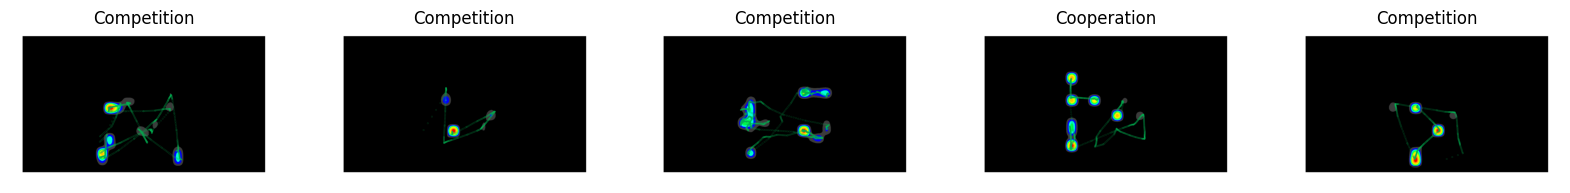

In [4]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        img_path = "./heatmapOn_trajOn/" + images[i]
        image = Image.open(img_path)
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(image)
        plt.axis("off")


sample_images_to_visualize = [train_ds[i]["image1"] for i in range(5)]
print(sample_images_to_visualize)
sample_captions = [train_ds[i]["class"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Step 3. Preprocess Data 

In [5]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [6]:
def transforms(example_batch):
    #images = [x for x in example_batch["image1"]]
    root = "./heatmapOn_trajOn/"
    images = [Image.open(root+image_path) for image_path in example_batch["image1"]]

    #print(images)
    captions = [x for x in example_batch["class"]]
    #print(captions)
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [7]:
print(train_ds[0])

{'input_ids': [101, 2971, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [9]:
from evaluate import load
import torch

wer = load("wer")



def compute_metrics(eval_pred):
    torch.cuda.empty_cache()
    with torch.no_grad():
        logits, labels = eval_pred
        predicted = logits.argmax(-1)
        decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
        decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
        wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)

    torch.cuda.empty_cache()
    return {"wer_score": wer_score}


In [9]:
from evaluate import load
import torch

# Load the metrics
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")



def compute_metrics(eval_pred):
    torch.cuda.empty_cache()
    with torch.no_grad():
        logits, labels = eval_pred
        predicted = logits.argmax(-1)

        # Flatten sequences for token-level metric computation
        decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
        decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)

        label_mapping = {"cooperation": 0, "single": 1, "competition": 2}
        encoded_labels = [label_mapping.get(label, 4) for label in decoded_labels]
        encoded_predictions = [label_mapping.get(pred, 4) for pred in decoded_predictions]

        # Calculate each metric
        accuracy = accuracy_metric.compute(predictions=encoded_predictions, references=encoded_labels)
        precision = precision_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")
        recall = recall_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")
        f1_score = f1_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")

    torch.cuda.empty_cache()
    return {
        "accuracy": accuracy['accuracy'],
        "precision": precision['precision'],
        "recall": recall['recall'],
        "f1_score": f1_score['f1']
    }


In [10]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="./vision_check",
    learning_rate=5e-5,
    num_train_epochs=10,
    fp16=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    eval_accumulation_steps=32,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to="none"
)

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [12]:
trainer.train()


  1%|▏         | 10/680 [00:31<34:22,  3.08s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
  1%|▏         | 10/680 [00:42<34:22,  3.08s/it]

{'eval_loss': 8.515304565429688, 'eval_accuracy': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1_score': 0.0, 'eval_runtime': 10.867, 'eval_samples_per_second': 8.282, 'eval_steps_per_second': 8.282, 'epoch': 0.15}


  3%|▎         | 20/680 [01:12<35:16,  3.21s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
  3%|▎         | 20/680 [01:23<35:16,  3.21s/it]

{'eval_loss': 7.441735744476318, 'eval_accuracy': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1_score': 0.0, 'eval_runtime': 10.7873, 'eval_samples_per_second': 8.343, 'eval_steps_per_second': 8.343, 'epoch': 0.29}


  4%|▍         | 30/680 [01:54<34:30,  3.19s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
  4%|▍         | 30/680 [02:04<34:30,  3.19s/it]

{'eval_loss': 6.434315204620361, 'eval_accuracy': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1_score': 0.0, 'eval_runtime': 10.4938, 'eval_samples_per_second': 8.576, 'eval_steps_per_second': 8.576, 'epoch': 0.44}


  6%|▌         | 40/680 [02:35<34:07,  3.20s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
  6%|▌         | 40/680 [02:46<34:07,  3.20s/it]

{'eval_loss': 5.39749813079834, 'eval_accuracy': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1_score': 0.0, 'eval_runtime': 10.6098, 'eval_samples_per_second': 8.483, 'eval_steps_per_second': 8.483, 'epoch': 0.58}


  7%|▋         | 50/680 [03:16<33:31,  3.19s/it]  

{'loss': 7.2418, 'grad_norm': 40.69937515258789, 'learning_rate': 4.639705882352942e-05, 'epoch': 0.73}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
  7%|▋         | 50/680 [03:27<33:31,  3.19s/it]

{'eval_loss': 4.354199409484863, 'eval_accuracy': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1_score': 0.0, 'eval_runtime': 10.5549, 'eval_samples_per_second': 8.527, 'eval_steps_per_second': 8.527, 'epoch': 0.73}


  9%|▉         | 60/680 [03:59<33:10,  3.21s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
  9%|▉         | 60/680 [04:10<33:10,  3.21s/it]

{'eval_loss': 3.3197567462921143, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.646, 'eval_samples_per_second': 8.454, 'eval_steps_per_second': 8.454, 'epoch': 0.87}


 10%|█         | 70/680 [04:40<31:26,  3.09s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
 10%|█         | 70/680 [04:51<31:26,  3.09s/it]

{'eval_loss': 2.3253276348114014, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.5348, 'eval_samples_per_second': 8.543, 'eval_steps_per_second': 8.543, 'epoch': 1.02}


 12%|█▏        | 80/680 [05:21<31:36,  3.16s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
 12%|█▏        | 80/680 [05:31<31:36,  3.16s/it]

{'eval_loss': 1.4369169473648071, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.4297, 'eval_samples_per_second': 8.629, 'eval_steps_per_second': 8.629, 'epoch': 1.16}


 13%|█▎        | 90/680 [06:02<31:01,  3.15s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
 13%|█▎        | 90/680 [06:12<31:01,  3.15s/it]

{'eval_loss': 0.7554407715797424, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.6279, 'eval_samples_per_second': 8.468, 'eval_steps_per_second': 8.468, 'epoch': 1.31}


 15%|█▍        | 100/680 [06:42<30:31,  3.16s/it] 

{'loss': 2.1551, 'grad_norm': 13.879600524902344, 'learning_rate': 4.272058823529412e-05, 'epoch': 1.45}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 15%|█▍        | 100/680 [06:53<30:31,  3.16s/it]

{'eval_loss': 0.334791898727417, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.541, 'eval_samples_per_second': 8.538, 'eval_steps_per_second': 8.538, 'epoch': 1.45}


 16%|█▌        | 110/680 [07:25<30:21,  3.19s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 16%|█▌        | 110/680 [07:36<30:21,  3.19s/it]

{'eval_loss': 0.1341032236814499, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.32135642135642134, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.348682625715146, 'eval_runtime': 10.671, 'eval_samples_per_second': 8.434, 'eval_steps_per_second': 8.434, 'epoch': 1.6}


 18%|█▊        | 120/680 [08:06<29:21,  3.15s/it]  /home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 18%|█▊        | 120/680 [08:16<29:21,  3.15s/it]

{'eval_loss': 0.05292794480919838, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.5692, 'eval_samples_per_second': 8.515, 'eval_steps_per_second': 8.515, 'epoch': 1.75}


 19%|█▉        | 130/680 [08:47<29:04,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 19%|█▉        | 130/680 [08:58<29:04,  3.17s/it]

{'eval_loss': 0.02117954008281231, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.6234, 'eval_samples_per_second': 8.472, 'eval_steps_per_second': 8.472, 'epoch': 1.89}


 21%|██        | 140/680 [09:27<27:45,  3.08s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 21%|██        | 140/680 [09:38<27:45,  3.08s/it]

{'eval_loss': 0.010493909940123558, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.6463, 'eval_samples_per_second': 8.454, 'eval_steps_per_second': 8.454, 'epoch': 2.04}


 22%|██▏       | 150/680 [10:08<27:52,  3.16s/it]

{'loss': 0.0857, 'grad_norm': 0.23285678029060364, 'learning_rate': 3.9044117647058823e-05, 'epoch': 2.18}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 22%|██▏       | 150/680 [10:19<27:52,  3.16s/it]

{'eval_loss': 0.006841756869107485, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.4773, 'eval_samples_per_second': 8.59, 'eval_steps_per_second': 8.59, 'epoch': 2.18}


 24%|██▎       | 160/680 [10:51<27:29,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 24%|██▎       | 160/680 [11:01<27:29,  3.17s/it]

{'eval_loss': 0.005731976591050625, 'eval_accuracy': 0.28888888888888886, 'eval_precision': 0.08345679012345678, 'eval_recall': 0.28888888888888886, 'eval_f1_score': 0.12950191570881225, 'eval_runtime': 10.3773, 'eval_samples_per_second': 8.673, 'eval_steps_per_second': 8.673, 'epoch': 2.33}


 25%|██▌       | 170/680 [11:31<26:46,  3.15s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 25%|██▌       | 170/680 [11:42<26:46,  3.15s/it]

{'eval_loss': 0.004908897913992405, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.4514, 'eval_samples_per_second': 8.611, 'eval_steps_per_second': 8.611, 'epoch': 2.47}


 26%|██▋       | 180/680 [12:12<26:15,  3.15s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 26%|██▋       | 180/680 [12:22<26:15,  3.15s/it]

{'eval_loss': 0.0044508581049740314, 'eval_accuracy': 0.4, 'eval_precision': 0.22928104575163397, 'eval_recall': 0.4, 'eval_f1_score': 0.25463342440801456, 'eval_runtime': 10.6137, 'eval_samples_per_second': 8.48, 'eval_steps_per_second': 8.48, 'epoch': 2.62}


 28%|██▊       | 190/680 [12:53<25:47,  3.16s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 28%|██▊       | 190/680 [13:03<25:47,  3.16s/it]

{'eval_loss': 0.004174117464572191, 'eval_accuracy': 0.32222222222222224, 'eval_precision': 0.5031565656565656, 'eval_recall': 0.32222222222222224, 'eval_f1_score': 0.18303480738263347, 'eval_runtime': 10.3475, 'eval_samples_per_second': 8.698, 'eval_steps_per_second': 8.698, 'epoch': 2.76}


 29%|██▉       | 200/680 [13:33<25:20,  3.17s/it]

{'loss': 0.0053, 'grad_norm': 0.08622606098651886, 'learning_rate': 3.5367647058823536e-05, 'epoch': 2.91}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 29%|██▉       | 200/680 [13:44<25:20,  3.17s/it]

{'eval_loss': 0.004285153467208147, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.6701, 'eval_samples_per_second': 8.435, 'eval_steps_per_second': 8.435, 'epoch': 2.91}


 31%|███       | 210/680 [14:16<24:48,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 31%|███       | 210/680 [14:27<24:48,  3.17s/it]

{'eval_loss': 0.004270648583769798, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.6699, 'eval_samples_per_second': 8.435, 'eval_steps_per_second': 8.435, 'epoch': 3.05}


 32%|███▏      | 220/680 [14:57<24:13,  3.16s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 32%|███▏      | 220/680 [15:07<24:13,  3.16s/it]

{'eval_loss': 0.0038045025430619717, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.4349, 'eval_samples_per_second': 8.625, 'eval_steps_per_second': 8.625, 'epoch': 3.2}


 34%|███▍      | 230/680 [15:38<23:39,  3.15s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 34%|███▍      | 230/680 [15:48<23:39,  3.15s/it]

{'eval_loss': 0.003505901899188757, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.4023, 'eval_samples_per_second': 8.652, 'eval_steps_per_second': 8.652, 'epoch': 3.35}


 35%|███▌      | 240/680 [16:18<23:07,  3.15s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 35%|███▌      | 240/680 [16:29<23:07,  3.15s/it]

{'eval_loss': 0.003568668384104967, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.5511, 'eval_samples_per_second': 8.53, 'eval_steps_per_second': 8.53, 'epoch': 3.49}


 37%|███▋      | 250/680 [16:59<22:42,  3.17s/it]

{'loss': 0.0038, 'grad_norm': 0.060192424803972244, 'learning_rate': 3.1691176470588236e-05, 'epoch': 3.64}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 37%|███▋      | 250/680 [17:10<22:42,  3.17s/it]

{'eval_loss': 0.0033780953381210566, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.28296070460704603, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.28634920634920635, 'eval_runtime': 10.4574, 'eval_samples_per_second': 8.606, 'eval_steps_per_second': 8.606, 'epoch': 3.64}


 38%|███▊      | 260/680 [17:42<22:19,  3.19s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 38%|███▊      | 260/680 [17:52<22:19,  3.19s/it]

{'eval_loss': 0.003262813901528716, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.30500000000000005, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.35518176885512753, 'eval_runtime': 10.4661, 'eval_samples_per_second': 8.599, 'eval_steps_per_second': 8.599, 'epoch': 3.78}


 40%|███▉      | 270/680 [18:23<21:38,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 40%|███▉      | 270/680 [18:33<21:38,  3.17s/it]

{'eval_loss': 0.0034138488117605448, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.503, 'eval_samples_per_second': 8.569, 'eval_steps_per_second': 8.569, 'epoch': 3.93}


 41%|████      | 280/680 [19:03<21:00,  3.15s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 41%|████      | 280/680 [19:13<21:00,  3.15s/it]

{'eval_loss': 0.003303573466837406, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.16901234567901233, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2395450568678915, 'eval_runtime': 10.4668, 'eval_samples_per_second': 8.599, 'eval_steps_per_second': 8.599, 'epoch': 4.07}


 43%|████▎     | 290/680 [19:44<20:35,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 43%|████▎     | 290/680 [19:54<20:35,  3.17s/it]

{'eval_loss': 0.003190097864717245, 'eval_accuracy': 0.4444444444444444, 'eval_precision': 0.315, 'eval_recall': 0.4444444444444444, 'eval_f1_score': 0.3657080846446012, 'eval_runtime': 10.2743, 'eval_samples_per_second': 8.76, 'eval_steps_per_second': 8.76, 'epoch': 4.22}


 44%|████▍     | 300/680 [20:24<20:05,  3.17s/it]

{'loss': 0.0033, 'grad_norm': 0.04674443230032921, 'learning_rate': 2.8014705882352942e-05, 'epoch': 4.36}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 44%|████▍     | 300/680 [20:35<20:05,  3.17s/it]

{'eval_loss': 0.003128036158159375, 'eval_accuracy': 0.36666666666666664, 'eval_precision': 0.2594771241830065, 'eval_recall': 0.36666666666666664, 'eval_f1_score': 0.3037878787878788, 'eval_runtime': 10.4994, 'eval_samples_per_second': 8.572, 'eval_steps_per_second': 8.572, 'epoch': 4.36}


 46%|████▌     | 310/680 [21:07<19:38,  3.18s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 46%|████▌     | 310/680 [21:17<19:38,  3.18s/it]

{'eval_loss': 0.0032780878245830536, 'eval_accuracy': 0.4222222222222222, 'eval_precision': 0.30193153566647546, 'eval_recall': 0.4222222222222222, 'eval_f1_score': 0.2927559912854031, 'eval_runtime': 10.4755, 'eval_samples_per_second': 8.592, 'eval_steps_per_second': 8.592, 'epoch': 4.51}


 47%|████▋     | 320/680 [21:48<18:57,  3.16s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 47%|████▋     | 320/680 [21:58<18:57,  3.16s/it]

{'eval_loss': 0.0030863936990499496, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.30500000000000005, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.35518176885512753, 'eval_runtime': 10.5417, 'eval_samples_per_second': 8.538, 'eval_steps_per_second': 8.538, 'epoch': 4.65}


 49%|████▊     | 330/680 [22:29<18:26,  3.16s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 49%|████▊     | 330/680 [22:39<18:26,  3.16s/it]

{'eval_loss': 0.003071705112233758, 'eval_accuracy': 0.4222222222222222, 'eval_precision': 0.30036057692307694, 'eval_recall': 0.4222222222222222, 'eval_f1_score': 0.34433028208481226, 'eval_runtime': 10.1889, 'eval_samples_per_second': 8.833, 'eval_steps_per_second': 8.833, 'epoch': 4.8}


                                                 
 50%|█████     | 340/680 [23:20<17:56,  3.17s/it]

{'eval_loss': 0.0031470018438994884, 'eval_accuracy': 0.37777777777777777, 'eval_precision': 0.32774230658613746, 'eval_recall': 0.37777777777777777, 'eval_f1_score': 0.3285002245664772, 'eval_runtime': 10.3919, 'eval_samples_per_second': 8.661, 'eval_steps_per_second': 8.661, 'epoch': 4.95}


 51%|█████▏    | 350/680 [23:50<17:17,  3.14s/it]

{'loss': 0.003, 'grad_norm': 0.05424141138792038, 'learning_rate': 2.433823529411765e-05, 'epoch': 5.09}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 51%|█████▏    | 350/680 [24:00<17:17,  3.14s/it]

{'eval_loss': 0.003064497373998165, 'eval_accuracy': 0.3888888888888889, 'eval_precision': 0.328968253968254, 'eval_recall': 0.3888888888888889, 'eval_f1_score': 0.3071280721850445, 'eval_runtime': 10.4652, 'eval_samples_per_second': 8.6, 'eval_steps_per_second': 8.6, 'epoch': 5.09}


 53%|█████▎    | 360/680 [24:32<16:55,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 53%|█████▎    | 360/680 [24:43<16:55,  3.17s/it]

{'eval_loss': 0.002972298301756382, 'eval_accuracy': 0.4222222222222222, 'eval_precision': 0.30193153566647546, 'eval_recall': 0.4222222222222222, 'eval_f1_score': 0.2927559912854031, 'eval_runtime': 10.4483, 'eval_samples_per_second': 8.614, 'eval_steps_per_second': 8.614, 'epoch': 5.24}


 54%|█████▍    | 370/680 [25:13<16:22,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 54%|█████▍    | 370/680 [25:23<16:22,  3.17s/it]

{'eval_loss': 0.0029537761583924294, 'eval_accuracy': 0.4, 'eval_precision': 0.2595833333333333, 'eval_recall': 0.4, 'eval_f1_score': 0.2805574805574806, 'eval_runtime': 10.3998, 'eval_samples_per_second': 8.654, 'eval_steps_per_second': 8.654, 'epoch': 5.38}


 56%|█████▌    | 380/680 [25:54<15:52,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 56%|█████▌    | 380/680 [26:04<15:52,  3.17s/it]

{'eval_loss': 0.002994575770571828, 'eval_accuracy': 0.4222222222222222, 'eval_precision': 0.31666666666666665, 'eval_recall': 0.4222222222222222, 'eval_f1_score': 0.3508878741755454, 'eval_runtime': 10.4477, 'eval_samples_per_second': 8.614, 'eval_steps_per_second': 8.614, 'epoch': 5.53}


 57%|█████▋    | 390/680 [26:35<15:19,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 57%|█████▋    | 390/680 [26:45<15:19,  3.17s/it]

{'eval_loss': 0.0029466452542692423, 'eval_accuracy': 0.37777777777777777, 'eval_precision': 0.26865721997300945, 'eval_recall': 0.37777777777777777, 'eval_f1_score': 0.31400749063670413, 'eval_runtime': 10.5422, 'eval_samples_per_second': 8.537, 'eval_steps_per_second': 8.537, 'epoch': 5.67}


 59%|█████▉    | 400/680 [27:16<14:48,  3.17s/it]

{'loss': 0.003, 'grad_norm': 0.043981585651636124, 'learning_rate': 2.066176470588235e-05, 'epoch': 5.82}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 59%|█████▉    | 400/680 [27:26<14:48,  3.17s/it]

{'eval_loss': 0.0030537317506968975, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.27256515775034296, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.2869114877589454, 'eval_runtime': 10.4928, 'eval_samples_per_second': 8.577, 'eval_steps_per_second': 8.577, 'epoch': 5.82}


 60%|██████    | 410/680 [27:58<14:21,  3.19s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 60%|██████    | 410/680 [28:08<14:21,  3.19s/it]

{'eval_loss': 0.002977343974635005, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.2923639226270805, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.34171516373763566, 'eval_runtime': 10.4631, 'eval_samples_per_second': 8.602, 'eval_steps_per_second': 8.602, 'epoch': 5.96}


 62%|██████▏   | 420/680 [28:38<13:39,  3.15s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 62%|██████▏   | 420/680 [28:49<13:39,  3.15s/it]

{'eval_loss': 0.00294444034807384, 'eval_accuracy': 0.3888888888888889, 'eval_precision': 0.2604166666666667, 'eval_recall': 0.3888888888888889, 'eval_f1_score': 0.29198966408268734, 'eval_runtime': 10.4328, 'eval_samples_per_second': 8.627, 'eval_steps_per_second': 8.627, 'epoch': 6.11}


 63%|██████▎   | 430/680 [29:19<13:08,  3.16s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 63%|██████▎   | 430/680 [29:30<13:08,  3.16s/it]

{'eval_loss': 0.003010398242622614, 'eval_accuracy': 0.4, 'eval_precision': 0.28228126373971485, 'eval_recall': 0.4, 'eval_f1_score': 0.3276077097505669, 'eval_runtime': 10.6128, 'eval_samples_per_second': 8.48, 'eval_steps_per_second': 8.48, 'epoch': 6.25}


                                                 
 65%|██████▍   | 440/680 [30:11<12:41,  3.17s/it]

{'eval_loss': 0.0029962456319481134, 'eval_accuracy': 0.4, 'eval_precision': 0.37578204771187224, 'eval_recall': 0.4, 'eval_f1_score': 0.3647896096676585, 'eval_runtime': 10.4906, 'eval_samples_per_second': 8.579, 'eval_steps_per_second': 8.579, 'epoch': 6.4}


 66%|██████▌   | 450/680 [30:41<12:07,  3.16s/it]

{'loss': 0.0028, 'grad_norm': 0.05423847958445549, 'learning_rate': 1.698529411764706e-05, 'epoch': 6.55}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 66%|██████▌   | 450/680 [30:52<12:07,  3.16s/it]

{'eval_loss': 0.002996662864461541, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.29089635854341733, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.3400552323873318, 'eval_runtime': 10.5998, 'eval_samples_per_second': 8.491, 'eval_steps_per_second': 8.491, 'epoch': 6.55}


                                                 
 68%|██████▊   | 460/680 [31:34<11:41,  3.19s/it]

{'eval_loss': 0.002910525305196643, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.43111111111111106, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.4173576561636263, 'eval_runtime': 10.5115, 'eval_samples_per_second': 8.562, 'eval_steps_per_second': 8.562, 'epoch': 6.69}


                                                 
 69%|██████▉   | 470/680 [32:15<11:06,  3.17s/it]

{'eval_loss': 0.0028778989799320698, 'eval_accuracy': 0.4444444444444444, 'eval_precision': 0.6070553870351645, 'eval_recall': 0.4444444444444444, 'eval_f1_score': 0.3851777157675179, 'eval_runtime': 10.5184, 'eval_samples_per_second': 8.556, 'eval_steps_per_second': 8.556, 'epoch': 6.84}


 71%|███████   | 480/680 [32:46<10:30,  3.15s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 71%|███████   | 480/680 [32:56<10:30,  3.15s/it]

{'eval_loss': 0.0030266831163316965, 'eval_accuracy': 0.37777777777777777, 'eval_precision': 0.2621991807475678, 'eval_recall': 0.37777777777777777, 'eval_f1_score': 0.30581369248035917, 'eval_runtime': 10.0963, 'eval_samples_per_second': 8.914, 'eval_steps_per_second': 8.914, 'epoch': 6.98}


                                                 
 72%|███████▏  | 490/680 [33:37<10:02,  3.17s/it]

{'eval_loss': 0.0029642307199537754, 'eval_accuracy': 0.36666666666666664, 'eval_precision': 0.3150211219176736, 'eval_recall': 0.36666666666666664, 'eval_f1_score': 0.3190066754937658, 'eval_runtime': 10.7949, 'eval_samples_per_second': 8.337, 'eval_steps_per_second': 8.337, 'epoch': 7.13}


 74%|███████▎  | 500/680 [34:07<09:30,  3.17s/it]

{'loss': 0.0027, 'grad_norm': 0.04729434847831726, 'learning_rate': 1.3308823529411765e-05, 'epoch': 7.27}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 74%|███████▎  | 500/680 [34:17<09:30,  3.17s/it]

{'eval_loss': 0.0031190873123705387, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.29129629629629633, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.33822873334539094, 'eval_runtime': 10.4714, 'eval_samples_per_second': 8.595, 'eval_steps_per_second': 8.595, 'epoch': 7.27}


 75%|███████▌  | 510/680 [34:49<09:00,  3.18s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 75%|███████▌  | 510/680 [35:00<09:00,  3.18s/it]

{'eval_loss': 0.0028905137442052364, 'eval_accuracy': 0.4222222222222222, 'eval_precision': 0.30136494252873564, 'eval_recall': 0.4222222222222222, 'eval_f1_score': 0.3500921796015462, 'eval_runtime': 10.5382, 'eval_samples_per_second': 8.54, 'eval_steps_per_second': 8.54, 'epoch': 7.42}


 76%|███████▋  | 520/680 [35:30<08:28,  3.18s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 76%|███████▋  | 520/680 [35:41<08:28,  3.18s/it]

{'eval_loss': 0.002897173399105668, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.3075846181109339, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.3586761229314421, 'eval_runtime': 10.506, 'eval_samples_per_second': 8.567, 'eval_steps_per_second': 8.567, 'epoch': 7.56}


 78%|███████▊  | 530/680 [36:11<07:55,  3.17s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 78%|███████▊  | 530/680 [36:22<07:55,  3.17s/it]

{'eval_loss': 0.002884950954467058, 'eval_accuracy': 0.4, 'eval_precision': 0.27876923076923077, 'eval_recall': 0.4, 'eval_f1_score': 0.3214932126696833, 'eval_runtime': 10.5399, 'eval_samples_per_second': 8.539, 'eval_steps_per_second': 8.539, 'epoch': 7.71}


                                                 
 79%|███████▉  | 540/680 [37:03<07:24,  3.17s/it]

{'eval_loss': 0.002818905748426914, 'eval_accuracy': 0.4222222222222222, 'eval_precision': 0.5800564971751412, 'eval_recall': 0.4222222222222222, 'eval_f1_score': 0.35987383582412824, 'eval_runtime': 10.4903, 'eval_samples_per_second': 8.579, 'eval_steps_per_second': 8.579, 'epoch': 7.85}


 81%|████████  | 550/680 [37:32<06:13,  2.87s/it]

{'loss': 0.0026, 'grad_norm': 0.0424693338572979, 'learning_rate': 9.632352941176471e-06, 'epoch': 8.0}


                                                 
 81%|████████  | 550/680 [37:43<06:13,  2.87s/it]

{'eval_loss': 0.0028462866321206093, 'eval_accuracy': 0.4222222222222222, 'eval_precision': 0.3993957115009747, 'eval_recall': 0.4222222222222222, 'eval_f1_score': 0.36669455492485187, 'eval_runtime': 10.521, 'eval_samples_per_second': 8.554, 'eval_steps_per_second': 8.554, 'epoch': 8.0}


 82%|████████▏ | 560/680 [38:15<06:23,  3.19s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 82%|████████▏ | 560/680 [38:26<06:23,  3.19s/it]

{'eval_loss': 0.0032786328811198473, 'eval_accuracy': 0.4, 'eval_precision': 0.2631590631590632, 'eval_recall': 0.4, 'eval_f1_score': 0.2907992202729045, 'eval_runtime': 10.6326, 'eval_samples_per_second': 8.465, 'eval_steps_per_second': 8.465, 'epoch': 8.15}


 84%|████████▍ | 570/680 [38:57<05:51,  3.19s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 84%|████████▍ | 570/680 [39:07<05:51,  3.19s/it]

{'eval_loss': 0.0031755834352225065, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.3090277777777778, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.3347114556416882, 'eval_runtime': 10.307, 'eval_samples_per_second': 8.732, 'eval_steps_per_second': 8.732, 'epoch': 8.29}


                                                 
 85%|████████▌ | 580/680 [39:47<05:17,  3.18s/it]

{'eval_loss': 0.0029976118821650743, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.31777777777777777, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.337037037037037, 'eval_runtime': 9.678, 'eval_samples_per_second': 9.299, 'eval_steps_per_second': 9.299, 'epoch': 8.44}


 87%|████████▋ | 590/680 [40:17<04:44,  3.16s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 87%|████████▋ | 590/680 [40:28<04:44,  3.16s/it]

{'eval_loss': 0.003036564216017723, 'eval_accuracy': 0.45555555555555555, 'eval_precision': 0.3457741976729318, 'eval_recall': 0.45555555555555555, 'eval_f1_score': 0.34282113329300257, 'eval_runtime': 10.5428, 'eval_samples_per_second': 8.537, 'eval_steps_per_second': 8.537, 'epoch': 8.58}


 88%|████████▊ | 600/680 [40:58<04:13,  3.17s/it]

{'loss': 0.0025, 'grad_norm': 0.05330028757452965, 'learning_rate': 5.955882352941177e-06, 'epoch': 8.73}


                                                 
 88%|████████▊ | 600/680 [41:09<04:13,  3.17s/it]

{'eval_loss': 0.0030667653772979975, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.3886666666666667, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.3419809786745271, 'eval_runtime': 10.4724, 'eval_samples_per_second': 8.594, 'eval_steps_per_second': 8.594, 'epoch': 8.73}


 90%|████████▉ | 610/680 [41:41<03:43,  3.19s/it]/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 90%|████████▉ | 610/680 [41:51<03:43,  3.19s/it]

{'eval_loss': 0.0027542072348296642, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.30814814814814817, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.35723156688973295, 'eval_runtime': 10.3685, 'eval_samples_per_second': 8.68, 'eval_steps_per_second': 8.68, 'epoch': 8.87}


                                                 
 91%|█████████ | 620/680 [42:32<03:04,  3.08s/it]

{'eval_loss': 0.0029587806202471256, 'eval_accuracy': 0.4666666666666667, 'eval_precision': 0.45479717813051146, 'eval_recall': 0.4666666666666667, 'eval_f1_score': 0.41041430765854725, 'eval_runtime': 10.417, 'eval_samples_per_second': 8.64, 'eval_steps_per_second': 8.64, 'epoch': 9.02}


                                                 
 93%|█████████▎| 630/680 [43:13<02:38,  3.16s/it]

{'eval_loss': 0.0028914292342960835, 'eval_accuracy': 0.45555555555555555, 'eval_precision': 0.5111090557816418, 'eval_recall': 0.45555555555555555, 'eval_f1_score': 0.40664698616083583, 'eval_runtime': 10.5435, 'eval_samples_per_second': 8.536, 'eval_steps_per_second': 8.536, 'epoch': 9.16}


                                                 
 94%|█████████▍| 640/680 [43:54<02:06,  3.17s/it]

{'eval_loss': 0.0028614236507564783, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.40238174851967956, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.40350165436372337, 'eval_runtime': 10.5924, 'eval_samples_per_second': 8.497, 'eval_steps_per_second': 8.497, 'epoch': 9.31}


 96%|█████████▌| 650/680 [44:24<01:34,  3.16s/it]

{'loss': 0.0023, 'grad_norm': 0.05327364802360535, 'learning_rate': 2.279411764705882e-06, 'epoch': 9.45}


                                                 
 96%|█████████▌| 650/680 [44:35<01:34,  3.16s/it]

{'eval_loss': 0.0029260094743222, 'eval_accuracy': 0.43333333333333335, 'eval_precision': 0.36991483462071695, 'eval_recall': 0.43333333333333335, 'eval_f1_score': 0.3829545454545455, 'eval_runtime': 10.5051, 'eval_samples_per_second': 8.567, 'eval_steps_per_second': 8.567, 'epoch': 9.45}


                                                 
 97%|█████████▋| 660/680 [45:17<01:03,  3.18s/it]

{'eval_loss': 0.0031625309493392706, 'eval_accuracy': 0.4, 'eval_precision': 0.33514336917562726, 'eval_recall': 0.4, 'eval_f1_score': 0.3433635478691799, 'eval_runtime': 10.5723, 'eval_samples_per_second': 8.513, 'eval_steps_per_second': 8.513, 'epoch': 9.6}


                                                 
 99%|█████████▊| 670/680 [45:57<00:31,  3.16s/it]

{'eval_loss': 0.002996637485921383, 'eval_accuracy': 0.45555555555555555, 'eval_precision': 0.44722222222222224, 'eval_recall': 0.45555555555555555, 'eval_f1_score': 0.4388235294117648, 'eval_runtime': 9.8059, 'eval_samples_per_second': 9.178, 'eval_steps_per_second': 9.178, 'epoch': 9.75}


                                                 
100%|██████████| 680/680 [46:38<00:00,  3.16s/it]

{'eval_loss': 0.0030497361440211535, 'eval_accuracy': 0.4111111111111111, 'eval_precision': 0.37051454718121385, 'eval_recall': 0.4111111111111111, 'eval_f1_score': 0.3720369285258539, 'eval_runtime': 10.6249, 'eval_samples_per_second': 8.471, 'eval_steps_per_second': 8.471, 'epoch': 9.89}


100%|██████████| 680/680 [46:40<00:00,  4.12s/it]

{'train_runtime': 2800.777, 'train_samples_per_second': 15.674, 'train_steps_per_second': 0.243, 'train_loss': 0.6996359299101373, 'epoch': 9.89}


TrainOutput(global_step=680, training_loss=0.6996359299101373, metrics={'train_runtime': 2800.777, 'train_samples_per_second': 15.674, 'train_steps_per_second': 0.243, 'total_flos': 2.031145696069632e+16, 'train_loss': 0.6996359299101373, 'epoch': 9.89090909090909})

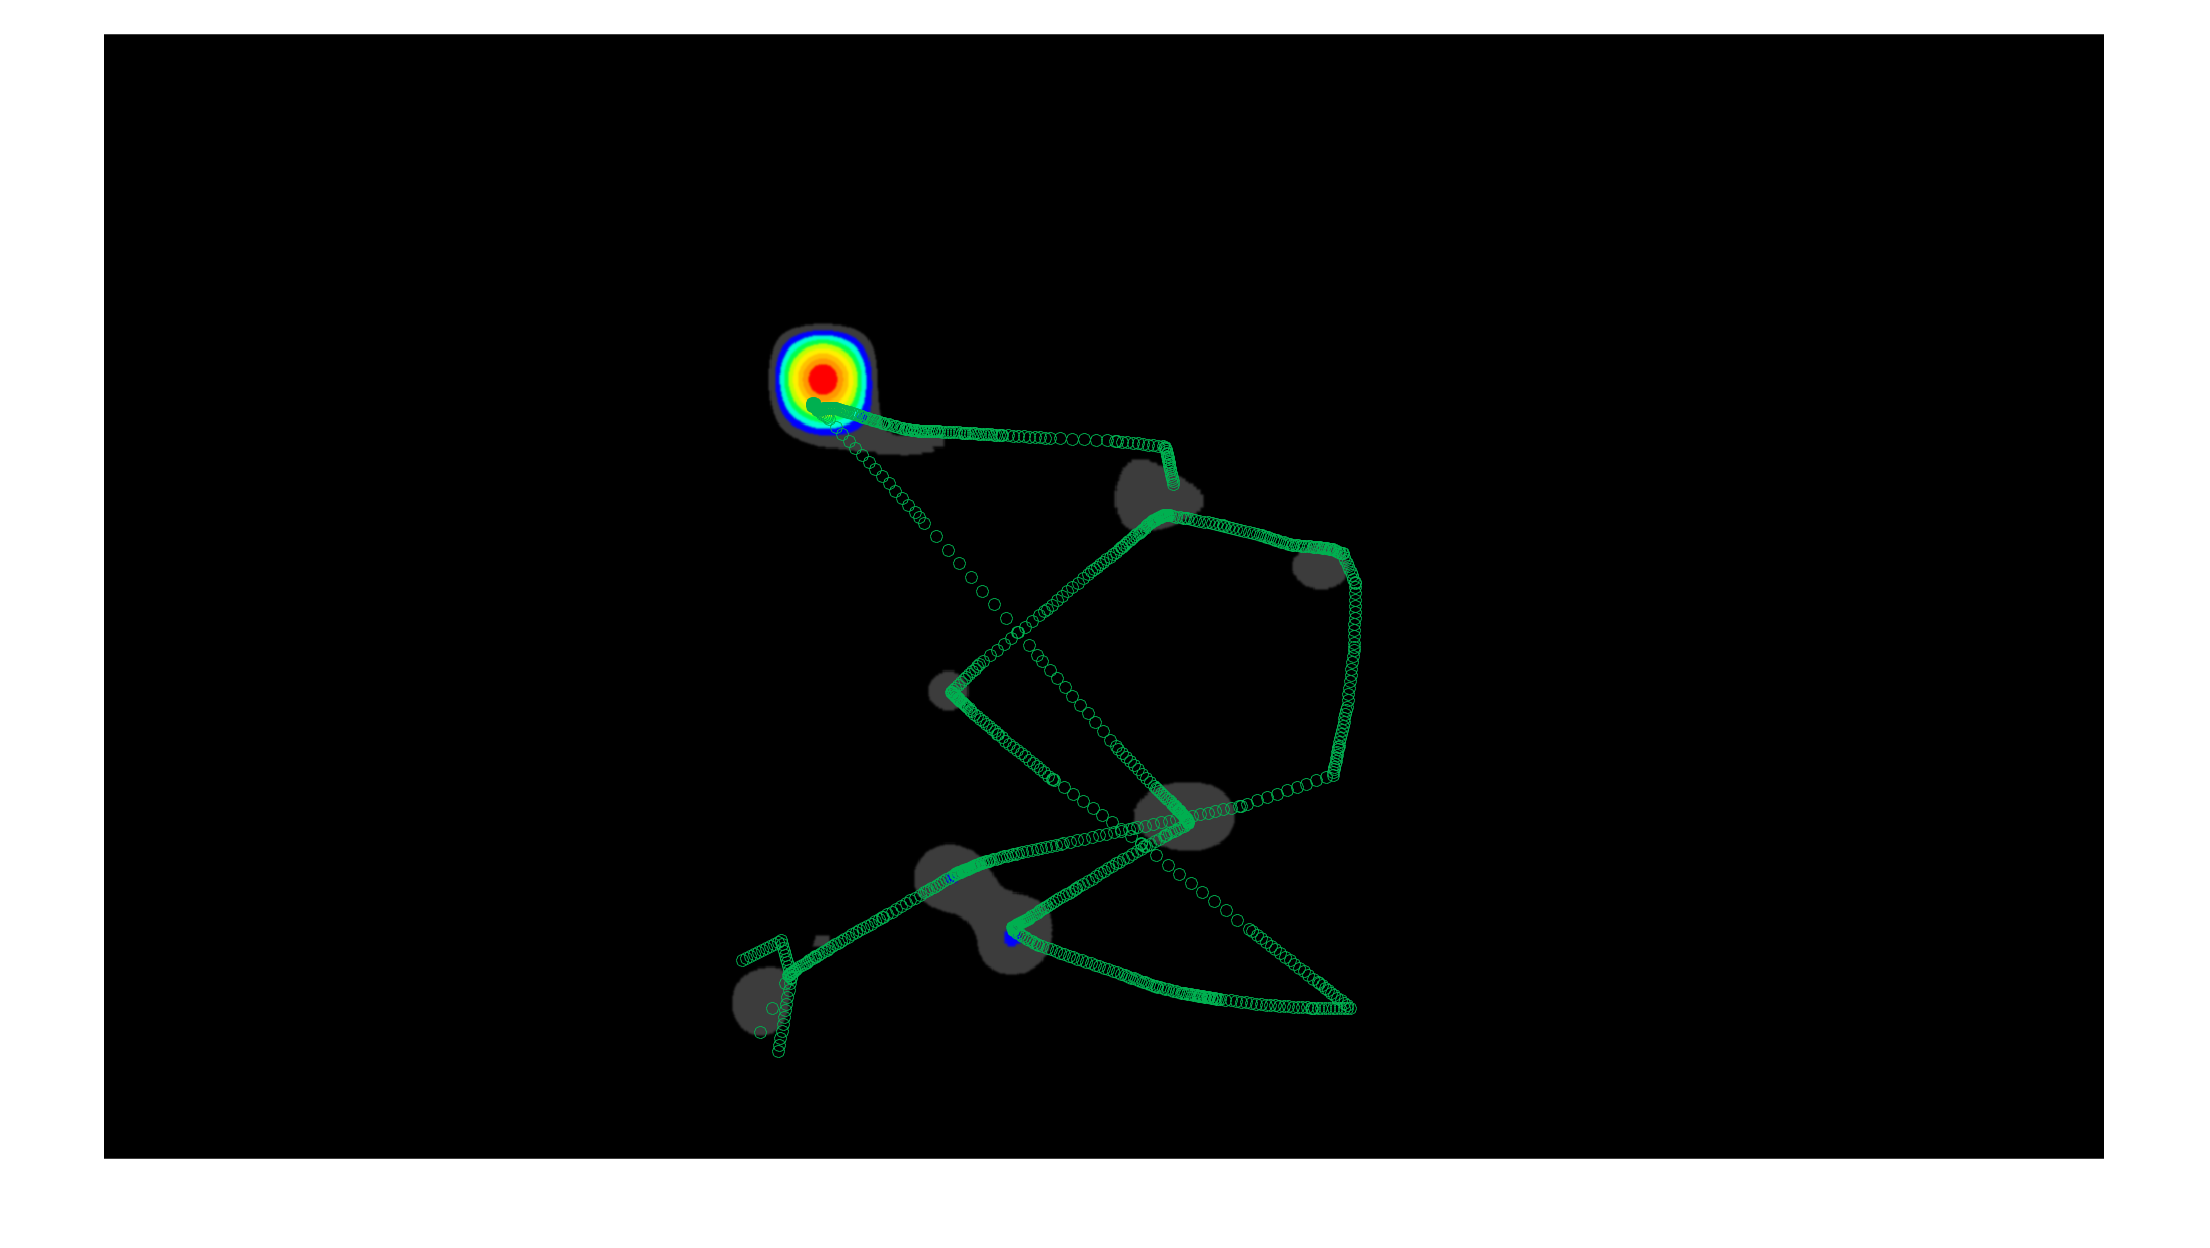

Predict:  single


In [22]:

image_path = "./heatmapOn_trajOn/heatmapOn_trajOn_Pair-13-A-Single-EYE_trial06_player.png"
image = Image.open(image_path)
display(image)

device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Predict: ", generated_caption)